# Model Testing and Evaluation

This notebook demonstrates testing and evaluating sentiment analysis models for both Vietnamese and English.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from src.config import Config
from src.models.model_predictor import SentimentPredictor
from src.data.preprocessor import DataPreprocessor
from src.features.feature_engineering import FeatureExtractor

In [2]:
def check_model_exists(language, config):
    """Check if trained model exists for given language"""
    model_path = os.path.join(config.DATA_DIR, "models", f"{language}_sentiment_model.pkl")
    return os.path.exists(model_path)

def load_model_components(language):
    """Load model components if model exists"""
    config = Config()
    
    if not check_model_exists(language, config):
        print(f"No trained model found for {language}")
        return None, None, None
        
    try:
        predictor = SentimentPredictor(language, config)
        preprocessor = DataPreprocessor(language, config)
        feature_extractor = FeatureExtractor(language, config)
        print(f"Successfully loaded model components for {language}")
        return predictor, preprocessor, feature_extractor
    except Exception as e:
        print(f"Error loading model for {language}: {str(e)}")
        return None, None, None

# Load available models
available_models = {}
for lang in ['vi', 'en']:
    components = load_model_components(lang)
    if all(components):
        available_models[lang] = {
            'predictor': components[0],
            'preprocessor': components[1],
            'feature_extractor': components[2]
        }

if not available_models:
    print("No models available for testing. Please train models first.")

Loaded feature extractor with 2619 dimensions
Successfully loaded model components for vi
No trained model found for en


## Test Individual Samples

In [3]:
def predict_sentiment(text, language='vi'):
    """Predict sentiment for a single text"""
    if language not in available_models:
        print(f"No model available for {language}")
        return None
    
    components = available_models[language]
    
    try:
        # Create DataFrame with single text and ensure it's a string
        df = pd.DataFrame({'text': [str(text)]})
        
        # Process text
        processed_df = components['preprocessor'].preprocess(df)
        if processed_df.empty:
            raise ValueError("Text preprocessing failed")
            
        # Extract features (now handles single documents)
        features = components['feature_extractor'].extract_features(processed_df['cleaned_text'])
        if features is None or features.size == 0:
            raise ValueError("Feature extraction failed")
            
        # Get predictions
        prediction = components['predictor'].predict(features)[0]
        probabilities = components['predictor'].predict_proba(features)[0]
        
        # Map sentiment to text
        sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        print(f"Text: {text}")
        print(f"Sentiment: {sentiment_map[prediction]} (confidence: {max(probabilities):.2f})")
        
        return prediction, probabilities
        
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return None

# Test samples for available languages
test_samples = {
    'vi': [
        "Sản phẩm tuyệt vời, rất đáng tiền",
        "Dịch vụ quá tệ, không bao giờ quay lại",
        "Tạm được, không tốt không xấu"
    ],
    'en': [
        "This product is amazing, totally worth it!",
        "Terrible service, never coming back",
        "It's okay, nothing special"
    ]
}

for lang in available_models:
    print(f"\nTesting {lang.upper()} model:")
    print("-" * 50)
    for sample in test_samples[lang]:
        predict_sentiment(sample, lang)
        print("-" * 30)


Testing VI model:
--------------------------------------------------
2024-11-11 05:02:35,973 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-11 05:02:36,122 - src.data.preprocessor - INFO - Preprocessed 1 valid samples
Text: Sản phẩm tuyệt vời, rất đáng tiền
Sentiment: Positive (confidence: 0.42)
------------------------------
2024-11-11 05:02:36,127 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-11 05:02:36,130 - src.data.preprocessor - INFO - Preprocessed 1 valid samples
Text: Dịch vụ quá tệ, không bao giờ quay lại
Sentiment: Positive (confidence: 0.42)
------------------------------
2024-11-11 05:02:36,134 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-11 05:02:36,137 - src.data.preprocessor - INFO - Preprocessed 1 valid samples
Text: Tạm được, không tốt không xấu
Sentiment: Neutral (confidence: 0.60)
------------------------------


## Batch Testing


Evaluating VI model:
--------------------------------------------------
2024-11-11 05:02:36,191 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-11 05:02:41,468 - src.data.preprocessor - INFO - Preprocessed 9958 valid samples


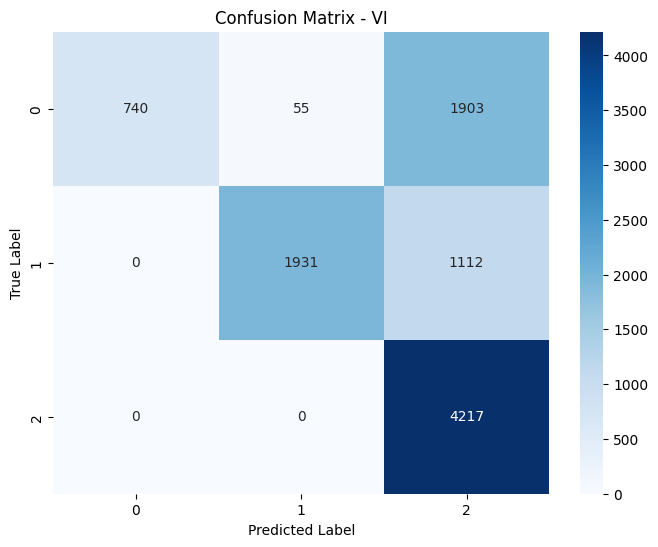


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.27      0.43      2698
           1       0.97      0.63      0.77      3043
           2       0.58      1.00      0.74      4217

    accuracy                           0.69      9958
   macro avg       0.85      0.64      0.65      9958
weighted avg       0.81      0.69      0.66      9958



In [4]:
def evaluate_model(test_data, language='vi'):
    """Evaluate model on test dataset"""
    if language not in available_models:
        print(f"No model available for {language}")
        return None, None, None
    
    components = available_models[language]
    
    try:
        # Validate input data
        if test_data.empty:
            raise ValueError("Empty test data provided")
        
        # Ensure required columns
        if 'text' not in test_data.columns:
            raise ValueError("Missing 'text' column")
        
        # Clean data
        test_data = test_data[test_data['text'].notna()].copy()
        test_data['text'] = test_data['text'].astype(str).str.strip()
        
        # Add default label if missing
        if 'label' not in test_data.columns:
            test_data['label'] = 1
        
        if len(test_data) == 0:
            raise ValueError("No valid samples after cleaning")
            
        # Process data
        processed_df = components['preprocessor'].preprocess(test_data)
        if processed_df.empty:
            raise ValueError("No samples after preprocessing")
        
        # Extract features
        features = components['feature_extractor'].extract_features(processed_df['cleaned_text'])
        if features is None or len(features) == 0:
            raise ValueError("Feature extraction failed")
        
        # Make predictions
        predictions = components['predictor'].predict(features)
        probabilities = components['predictor'].predict_proba(features)
        
        # Calculate metrics if we have labels
        if 'label' in processed_df.columns:
            conf_matrix = confusion_matrix(processed_df['label'], predictions)
            class_report = classification_report(processed_df['label'], predictions)
            
            # Plot confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - {language.upper()}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
            
            print("\nClassification Report:")
            print(class_report)
        
        return predictions, probabilities, processed_df
        
    except Exception as e:
        print(f"Error evaluating model: {str(e)}")
        return None, None, None

# Evaluate available models
for lang in available_models:
    print(f"\nEvaluating {lang.upper()} model:")
    print("-" * 50)
    
    try:
        test_data = pd.read_csv(os.path.join(project_root, 'data', 'processed', f'{lang}_processed_data.csv'))
        evaluate_model(test_data, lang)
    except Exception as e:
        print(f"Error loading test data for {lang}: {str(e)}")

# Error Analysis

Vietnamese Error Analysis:
2024-11-11 05:02:43,999 - src.data.preprocessor - INFO - Preprocessing vi data...


2024-11-11 05:02:49,191 - src.data.preprocessor - INFO - Preprocessed 9958 valid samples


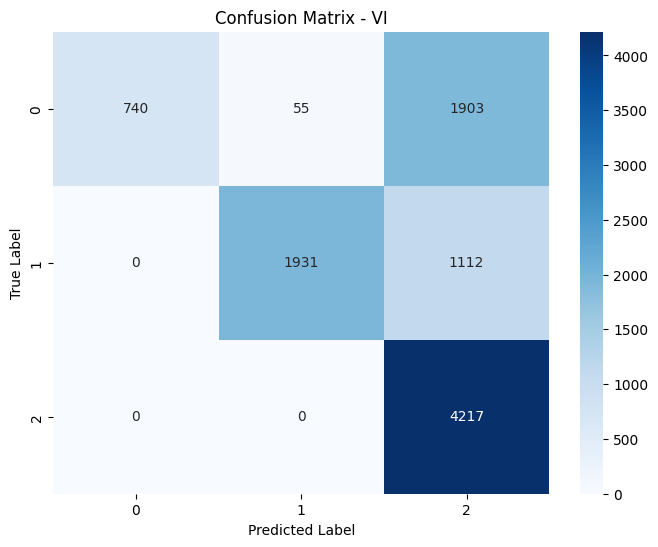


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.27      0.43      2698
           1       0.97      0.63      0.77      3043
           2       0.58      1.00      0.74      4217

    accuracy                           0.69      9958
   macro avg       0.85      0.64      0.65      9958
weighted avg       0.81      0.69      0.66      9958

Total errors: 3070

Sample errors with highest confidence:
                                                   text  label  predicted  \
4603                    Phục vụ như c*t, chậm trễ...>.<      0          1   
4943                      Phục vụ như c*t, chậm trễ 😢!!      0          1   
3719                      đét Phục vụ như c*t, chậm trễ      0          1   
3307                  Phục vụ như c*t, chậm trễ, quá tệ      0          1   
2069  Tạm ổn, thất rat worth!, bình thường tương đối...      1          2   

      confidence  
4603       0.747  
4943       0.747  
3719       0.727

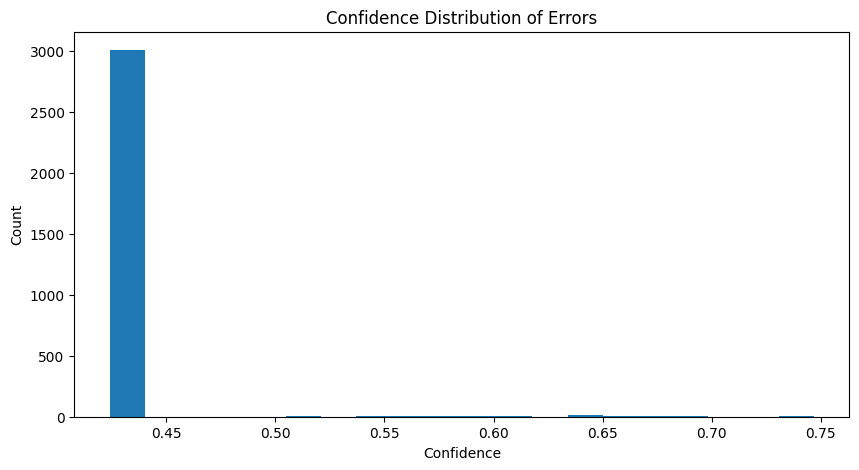


English Error Analysis:
No model available for en
Missing required data for error analysis


In [5]:
def analyze_errors(test_data, predictions, probabilities, language='vi'):
    """Analyze prediction errors with better error handling"""
    if any(x is None for x in [test_data, predictions, probabilities]):
        print("Missing required data for error analysis")
        return None
        
    try:
        df = test_data.copy()
        df['predicted'] = predictions
        df['confidence'] = np.max(probabilities, axis=1)
        
        # Find misclassified samples
        errors = df[df['label'] != df['predicted']].copy()
        errors['confidence'] = errors['confidence'].round(3)
        
        print(f"Total errors: {len(errors)}")
        print("\nSample errors with highest confidence:")
        print(errors.sort_values('confidence', ascending=False)[['text', 'label', 'predicted', 'confidence']].head())
        
        # Plot confidence distribution
        plt.figure(figsize=(10, 5))
        plt.hist(errors['confidence'], bins=20)
        plt.title('Confidence Distribution of Errors')
        plt.xlabel('Confidence')
        plt.ylabel('Count')
        plt.show()
        
        return errors
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        return None

# Evaluate models and analyze errors for both languages
print("Vietnamese Error Analysis:")
vi_test_data = pd.read_csv(os.path.join(project_root, 'data', 'processed', 'vi_processed_data.csv'))
vi_results = evaluate_model(vi_test_data, 'vi')
vi_errors = analyze_errors(vi_test_data, vi_results[0], vi_results[1], 'vi')

print("\nEnglish Error Analysis:")
en_test_data = pd.read_csv(os.path.join(project_root, 'data', 'processed', 'en_processed_data.csv'))
en_results = evaluate_model(en_test_data, 'en')
en_errors = analyze_errors(en_test_data, en_results[0], en_results[1], 'en')